# How to Build A RAG System Using Claude 3 And MongoDB


This tutorial implements a chatbot prompted to take on the role of a Venture capital tech Analyst. The chatbot is a naive RAG system with a collection of tech news articles acting as its knowledge source.
This notebook covers the following:

1. Follow a comprehensive tutorial on setting up your development environment, from installing necessary libraries to configuring a MongoDB database.
2. Learn efficient data handling methods, including creating vector search indexes and preparing data for ingestion and query processing.
3. Understand how to employ Claude 3 models within the RAG system for generating precise responses based on contextual information retrieved from the database.


You will need the following:
- Anthropic API Key
- VoyageAI API Key
- Hugging Face Access Token

## Step 1: Library installation, data loading and preparation


Below are brief explanations of the tools and libraries utilised within the implementation code:
- anthropic:  The official Python library for Anthropic that enables access to state-of-the-art language models. This library provides access to the Claude 3 family models, which can understand text and images.
- datasets: This library is part of the Hugging Face ecosystem. By installing 'datasets', we gain access to a number of pre-processed and ready-to-use datasets, which are essential for training and fine-tuning machine learning models or benchmarking their performance.
- pandas: This data science library provides robust data structures and methods for data manipulation, processing, and analysis.
- voyageai: This is the official Python client library for accessing VoyageAI's suite of embedding models.
- pymongo: PyMongo is a Python toolkit for MongoDB. It enables interactions with a MongoDB database.



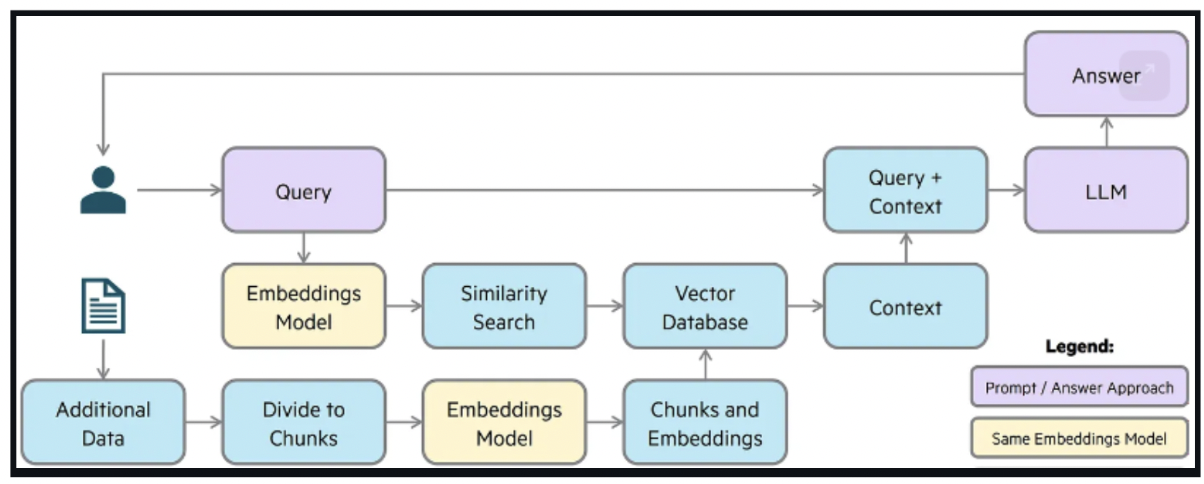

In [1]:
!pip install pymongo datasets pandas anthropic voyageai

The code snippet below executes the following steps:
1. Import Necessary Libraries:
- `os` for interacting with the operating system,
- `requests` for making HTTP requests,
- `BytesIO` from the io module to handle bytes objects like files in memory,
- `pandas` (as pd) for data manipulation and analysis, and
- `userdata` from google.colab enables access to environment variables stored in Google Colab secrets.
2. Function Definition: The `download_and_combine_parquet_files` function is defined with two parameters:
- `parquet_file_urls`: a list of URLs as strings, each pointing to a Parquet file that contains a sub-collection of the tech-news-embedding dataset.
- `hf_token` is a string representing a Hugging Face authorization token. Access tokens can be created or copied from the [Hugging Face platform](https://huggingface.co/docs/hub/en/security-tokens#:~:text=To%20create%20an%20access%20token,you%27re%20ready%20to%20go!)
3. Download and Read Parquet Files: The function iterates over each URL in parquet_file_urls. For each URL, it:
- Makes a GET request using the requests.get method, passing the URL and the headers for authorization.
- Checks if the response status code is 200 (OK), indicating the request was successful.
- If successful, it reads the content of the response into a BytesIO object (to handle it as a file in memory), then uses pandas.read_parquet to read the Parquet file from this object into a Pandas DataFrame.
- Appends the DataFrame to the list all_dataframes.
4. Combine DataFrames: After downloading and reading all Parquet files into DataFrames, there’s a check to ensure that `all_dataframes` is not empty. If there are DataFrames to work with, then all DataFrames are concatenated into a single DataFrame using pd.concat, with ignore_index=True to reindex the new combined DataFrame. This combined DataFrame is the overall process output in the `download_and_combine_parquet_files` function.

In [2]:
import os
import requests
from io import BytesIO
import pandas as pd
from google.colab import userdata

def download_and_combine_parquet_files(parquet_file_urls, hf_token):
    """
    Downloads Parquet files from the provided URLs using the given Hugging Face token,
    and returns a combined DataFrame.

    Parameters:
    - parquet_file_urls: List of strings, URLs to the Parquet files.
    - hf_token: String, Hugging Face authorization token.

    Returns:
    - combined_df: A pandas DataFrame containing the combined data from all Parquet files.
    """
    headers = {"Authorization": f"Bearer {hf_token}"}
    all_dataframes = []

    for parquet_file_url in parquet_file_urls:
        response = requests.get(parquet_file_url, headers=headers)
        if response.status_code == 200:
            parquet_bytes = BytesIO(response.content)
            df = pd.read_parquet(parquet_bytes)
            all_dataframes.append(df)
        else:
            print(f"Failed to download Parquet file from {parquet_file_url}: {response.status_code}")

    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        return combined_df
    else:
        print("No dataframes to concatenate.")
        return None

Below is a list of the Parquet files required for this tutorial. The complete list of all files is located [here](https://huggingface.co/datasets/MongoDB/tech-news-embeddings/tree/refs%2Fconvert%2Fparquet/default/train). Each Parquet file represents approximately 45,000 data points.

In the code snippet below, a subset of the tech-news-embeddings dataset is grouped into a single DataFrame, which is then assigned to the variable `combined_df`.


In [3]:
from google.colab import userdata
HF_TOKEN=userdata.get('HUGGING_FACE_HUB_TOKEN')
ANTHROPIC_API_KEY=userdata.get('ANTHROPIC_API_KEY')

In [19]:
# Uncomment the links below to load more data
# For the full list of data visit: https://huggingface.co/datasets/MongoDB/tech-news-embeddings/tree/refs%2Fconvert%2Fparquet/default/train
parquet_files = [
    "https://huggingface.co/api/datasets/AIatMongoDB/tech-news-embeddings/parquet/default/train/0000.parquet",
    # "https://huggingface.co/api/datasets/AIatMongoDB/tech-news-embeddings/parquet/default/train/0001.parquet",
    # "https://huggingface.co/api/datasets/AIatMongoDB/tech-news-embeddings/parquet/default/train/0002.parquet",
    # "https://huggingface.co/api/datasets/AIatMongoDB/tech-news-embeddings/parquet/default/train/0003.parquet",
    # "https://huggingface.co/api/datasets/AIatMongoDB/tech-news-embeddings/parquet/default/train/0004.parquet",
    # "https://huggingface.co/api/datasets/AIatMongoDB/tech-news-embeddings/parquet/default/train/0005.parquet",
]

hf_token = userdata.get("HUGGING_FACE_HUB_TOKEN")
combined_df = download_and_combine_parquet_files(parquet_files, hf_token)

As a final phase in data preparation, the code snippet below shows the step to remove the `_id` column from the grouped dataset, as it is unnecessary for subsequent steps in this tutorial. Additionally, the data within the embedding column for each data point is converted from a numpy array to a Python list to prevent errors related to incompatible data types during the data ingestion.


In [20]:
combined_df.head()

,_id,companyName,companyUrl,published_at,url,title,main_image,description,embedding
0,65c63ea1f187c085a866f680,01Synergy,https://hackernoon.com/company/01synergy,2023-05-16 02:09:00,https://www.businesswire.com/news/home/2023051...,onsemi and Sineng Electric Spearhead the Devel...,https://firebasestorage.googleapis.com/v0/b/ha...,(Nasdaq: ON) a leader in intelligent power and...,"[0.05243798345327377, -0.10347484797239304, -0..."
1,65c63ea2f187c085a866f681,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 00:07:00,https://elkodaily.com/news/local/adobe-student...,Adobe student receives national Information an...,https://firebasestorage.googleapis.com/v0/b/ha...,ELKO — An eighth grader at Adobe Middle School...,"[0.0036485784221440554, -0.05992984399199486, ..."
2,65c63ea2f187c085a866f682,01Synergy,https://hackernoon.com/company/01synergy,2023-05-01 22:22:00,https://www.aei.org/technology-and-innovation/...,Modernizing State Services: Harnessing Technol...,https://firebasestorage.googleapis.com/v0/b/ha...,To deliver 21st-century government services Go...,"[0.012319465167820454, -0.0807630866765976, 0...."
3,65c63ea2f187c085a866f683,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 13:12:00,https://www.crn.com/news/managed-services/terr...,Terry Richardson On Why He Left AMD GreenPages...,https://firebasestorage.googleapis.com/v0/b/ha...,In February GreenPages acquired Toronto-based ...,"[-0.02363203465938568, 0.021521812304854393, 0..."
4,65c63ea7f187c085a866f684,01Synergy,https://hackernoon.com/company/01synergy,2023-05-15 20:01:00,https://www.benzinga.com/pressreleases/23/05/3...,Synex Renewable Energy Corporation (Formerly S...,https://firebasestorage.googleapis.com/v0/b/ha...,The conference will bring together growth orie...,"[0.08473014086484909, -0.07019763439893723, 0...."


In [6]:
# Remove the _id coloum from the intital dataset
combined_df = combined_df.drop(columns=['_id'])

# Remove the initial embedding coloumn as we are going to create new embeddings with VoyageAI embedding model
combined_df = combined_df.drop(columns=['embedding'])

In [7]:
combined_df.head()

,companyName,companyUrl,published_at,url,title,main_image,description
0,01Synergy,https://hackernoon.com/company/01synergy,2023-05-16 02:09:00,https://www.businesswire.com/news/home/2023051...,onsemi and Sineng Electric Spearhead the Devel...,https://firebasestorage.googleapis.com/v0/b/ha...,(Nasdaq: ON) a leader in intelligent power and...
1,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 00:07:00,https://elkodaily.com/news/local/adobe-student...,Adobe student receives national Information an...,https://firebasestorage.googleapis.com/v0/b/ha...,ELKO — An eighth grader at Adobe Middle School...
2,01Synergy,https://hackernoon.com/company/01synergy,2023-05-01 22:22:00,https://www.aei.org/technology-and-innovation/...,Modernizing State Services: Harnessing Technol...,https://firebasestorage.googleapis.com/v0/b/ha...,To deliver 21st-century government services Go...
3,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 13:12:00,https://www.crn.com/news/managed-services/terr...,Terry Richardson On Why He Left AMD GreenPages...,https://firebasestorage.googleapis.com/v0/b/ha...,In February GreenPages acquired Toronto-based ...
4,01Synergy,https://hackernoon.com/company/01synergy,2023-05-15 20:01:00,https://www.benzinga.com/pressreleases/23/05/3...,Synex Renewable Energy Corporation (Formerly S...,https://firebasestorage.googleapis.com/v0/b/ha...,The conference will bring together growth orie...


In [8]:
# Limiting the amount of document used to 500 for this demo due to the rate limit on VoyageAI API
# Read more on VoyageAI rate limits: https://docs.voyageai.com/docs/rate-limits
max_documents = 200

if len(combined_df) > max_documents:
    combined_df = combined_df[:max_documents]

In [9]:
import voyageai
import time

vo = voyageai.Client(api_key=userdata.get("VOYAGE_API_KEY"))

def get_embedding(text: str) -> list[float]:
    if not text.strip():
      print("Attempted to get embedding for empty text.")
      return []

    embedding = vo.embed(text, model="voyage-large-2", input_type="document")

    return embedding.embeddings[0]

combined_df["embedding"] = combined_df["description"].apply(get_embedding)

combined_df.head()

,companyName,companyUrl,published_at,url,title,main_image,description,embedding
0,01Synergy,https://hackernoon.com/company/01synergy,2023-05-16 02:09:00,https://www.businesswire.com/news/home/2023051...,onsemi and Sineng Electric Spearhead the Devel...,https://firebasestorage.googleapis.com/v0/b/ha...,(Nasdaq: ON) a leader in intelligent power and...,"[0.01779516600072384, 0.010799395851790905, 0...."
1,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 00:07:00,https://elkodaily.com/news/local/adobe-student...,Adobe student receives national Information an...,https://firebasestorage.googleapis.com/v0/b/ha...,ELKO — An eighth grader at Adobe Middle School...,"[0.01387058012187481, 0.0040215072222054005, 0..."
2,01Synergy,https://hackernoon.com/company/01synergy,2023-05-01 22:22:00,https://www.aei.org/technology-and-innovation/...,Modernizing State Services: Harnessing Technol...,https://firebasestorage.googleapis.com/v0/b/ha...,To deliver 21st-century government services Go...,"[-0.013525871559977531, -0.0019979116041213274..."
3,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 13:12:00,https://www.crn.com/news/managed-services/terr...,Terry Richardson On Why He Left AMD GreenPages...,https://firebasestorage.googleapis.com/v0/b/ha...,In February GreenPages acquired Toronto-based ...,"[0.00893993116915226, -0.016197018325328827, 0..."
4,01Synergy,https://hackernoon.com/company/01synergy,2023-05-15 20:01:00,https://www.benzinga.com/pressreleases/23/05/3...,Synex Renewable Energy Corporation (Formerly S...,https://firebasestorage.googleapis.com/v0/b/ha...,The conference will bring together growth orie...,"[0.025389516726136208, 0.0015387400053441525, ..."


## Step 2: Database and collection creation

**To create a new MongoDB database, set up a database cluster:**
1. Register for a [free MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register?utm_campaign=devrel&utm_source=community&utm_medium=cta&utm_content=Partner%20Cookbook&utm_term=richmond.alake), or existing users, [sign into MongoDB Atlas](https://account.mongodb.com/account/login?utm_campaign=devrel&utm_source=community&utm_medium=cta&utm_content=Partner%20Cookbook&utm_term=richmond.alake)
2. Select the “Database” option on the left-hand pane, which will navigate to the Database Deployment page with a deployment specification of any existing cluster. Create a new database cluster by clicking on the "+Create" button.
3. For assistance with database cluster setup and obtaining the URI, refer to our guide for setting up a MongoDB cluster and getting your connection string.
Note: Don’t forget to whitelist the IP for the Python host or 0.0.0.0/0 for any IP when creating proof of concepts.
4. After successfully creating and deploying the cluster, the cluster becomes accessible on the ‘Database Deployment’ page.
5. Click on the “Connect” button of the cluster to view the option to set up a connection to the cluster via various language drivers.
6. This tutorial only requires the cluster’s URI(unique resource identifier). Grab the URI and copy it into the Google Colabs Secrets environment in a variable named MONGO_URI or place it in a .env file or equivalent.


Once you have created a cluster, navigate to the cluster page and create a database and collection within the MongoDB Atlas cluster by clicking + Create Database.
The database will be named `tech_news`, and the collection will be named `hacker_noon_tech_news`.



## Step 3: Vector search index creation

By this point, you have created a cluster, database and collection.

The steps in this section are crucial to ensure that a vector search can be conducted using the queries entered into the chatbot and searched against the records within the hacker_noon_tech_news collection. The objective of this step is to create a vector search index. To achieve this, refer to the official [vector search index creation guide](https://www.mongodb.com/docs/atlas/atlas-vector-search/create-index/).

In the creation of a vector search index using the JSON editor on MongoDB Atlas, ensure your vector search index is named vector_index and the vector search index definition is as follows:

```
{
 "fields": [{
     "numDimensions": 1536,
     "path": "embedding",
     "similarity": "cosine",
     "type": "vector"
   }]
}

```

## Step 4: Data ingestion

To ingest data into the MongoDB database created in previous steps. The following operations have to be carried out:
- Connect to the database and collection
- Clear out the collection of any existing records
- Convert the Pandas DataFrame of the dataset into dictionaries before ingestion
- Ingest dictionaries into MongoDB using a batch operation

This tutorial requires the cluster's URI (unique resource identifier). Grab the URI and copy it into the Google Colab Secrets environment in a variable named MONGO_URI, or place it in a .env file or equivalent.


In [10]:
MONGODB_DATABASE=userdata.get('MONGODB_DATABASE')
MONGODB_COLLECTION=userdata.get('MONGODB_COLLECTION')
CLUSTER_URI=userdata.get('CLUSTER_URI')

In [11]:
import pymongo
from google.colab import userdata

def get_mongo_client(mongo_uri):
  """Establish connection to the MongoDB."""
  try:
    client = pymongo.MongoClient(mongo_uri)
    print("Connection to MongoDB successful")
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f"Connection failed: {e}")
    return None

mongo_uri = userdata.get('CLUSTER_URI')
if not mongo_uri:
  print("CLUSTER_URI not set in environment variables")

mongo_client = get_mongo_client(mongo_uri)

DB_NAME="tech_news"
COLLECTION_NAME="hacker_noon_tech_news"

db = mongo_client[MONGODB_DATABASE]
collection = db[MONGODB_COLLECTION]

Connection to MongoDB successful


In [12]:
# To ensure we are working with a fresh collection
# delete any existing records in the collection
collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000006'), 'opTime': {'ts': Timestamp(1710601618, 1), 't': 6}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1710601618, 1), 'signature': {'hash': b':>\xf2\x04Cn#\x15k\xbaj!-\xfc\xe7q \xaf\x90\xf0', 'keyId': 7332493404682584069}}, 'operationTime': Timestamp(1710601618, 1)}, acknowledged=True)

In [13]:
# Data Ingestion
combined_df_json = combined_df.to_dict(orient='records')

In [14]:
collection.insert_many(combined_df_json)

InsertManyResult([ObjectId('65f5b596a2624be65ec8378a'), ObjectId('65f5b596a2624be65ec8378b'), ObjectId('65f5b596a2624be65ec8378c'), ObjectId('65f5b596a2624be65ec8378d'), ObjectId('65f5b596a2624be65ec8378e'), ObjectId('65f5b596a2624be65ec8378f'), ObjectId('65f5b596a2624be65ec83790'), ObjectId('65f5b596a2624be65ec83791'), ObjectId('65f5b596a2624be65ec83792'), ObjectId('65f5b596a2624be65ec83793'), ObjectId('65f5b596a2624be65ec83794'), ObjectId('65f5b596a2624be65ec83795'), ObjectId('65f5b596a2624be65ec83796'), ObjectId('65f5b596a2624be65ec83797'), ObjectId('65f5b596a2624be65ec83798'), ObjectId('65f5b596a2624be65ec83799'), ObjectId('65f5b596a2624be65ec8379a'), ObjectId('65f5b596a2624be65ec8379b'), ObjectId('65f5b596a2624be65ec8379c'), ObjectId('65f5b596a2624be65ec8379d'), ObjectId('65f5b596a2624be65ec8379e'), ObjectId('65f5b596a2624be65ec8379f'), ObjectId('65f5b596a2624be65ec837a0'), ObjectId('65f5b596a2624be65ec837a1'), ObjectId('65f5b596a2624be65ec837a2'), ObjectId('65f5b596a2624be65ec837

## Step 5: Vector Search

This section showcases the creation of a vector search custom function that accepts a user query, which corresponds to entries to the chatbot. The function also takes a second parameter, `collection`, which points to the database collection containing records against which the vector search operation should be conducted.

The `vector_search` function produces a vector search result derived from a series of operations outlined in a MongoDB aggregation pipeline. This pipeline includes the `$vectorSearch` and `$project` stages and performs queries based on the vector embeddings of user queries. It then formats the results, omitting any record attributes unnecessary for subsequent processes.

The code snippet below conducts the following operations to allow semantic search for movies:
1. Define the `vector_search` function that takes a user's query string and a MongoDB collection as inputs and returns a list of documents that match the query based on vector similarity search.
2. Generate an embedding for the user's query by calling the previously defined function, `get_embedding`, which converts the query string into a vector representation.
3. Construct a pipeline for MongoDB's aggregate function, incorporating two main stages: `$vectorSearch` and `$project`.
4. The `$vectorSearch` stage performs the actual vector search. The index field specifies the vector index to utilise for the vector search, and this should correspond to the name entered in the vector search index definition in previous steps. The queryVector field takes the embedding representation of the use query. The path field corresponds to the document field containing the embeddings.  The `numCandidates` specifies the number of candidate documents to consider and the limit on the number of results to return.
5. The $project stage formats the results to excludes the _id  the `embedding` field.
6. The aggregate executes the defined pipeline to obtain the vector search results. The final operation converts the returned cursor from the database into a list.

In [15]:
def vector_search(user_query, collection):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search pipeline
    pipeline = [
        {
            "$vectorSearch": {
                "index": "vector_index",
                "queryVector": query_embedding,
                "path": "embedding",
                "numCandidates": 150,  # Number of candidate matches to consider
                "limit": 5  # Return top 5 matches
            }
        },
        {
            "$project": {
                "_id": 0,  # Exclude the _id field
                "embedding": 0,  # Exclude the embedding field
                "score": {
                    "$meta": "vectorSearchScore"  # Include the search score
                }
            }
        }
    ]

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)


## Step 6: Handling user queries with Claude 3 models

The final section of the tutorial outlines the sequence of operations performed as follows:

- Accept a user query in the form of a string.
- Utilize the VoyageAI embedding model to generate embeddings for the user query.
- Load the Anthropic Claude 3, specifically the ‘claude-3-opus-20240229’ model, to serve as the base model for the RAG system.
- Execute a vector search using the embeddings of the user query to fetch relevant information from the knowledge base, which provides additional context for the base model.
- Submit both the user query and the gathered additional information to the base model to generate a response.


An important note is that the dimensions of the user query embedding match the dimensions set in the vector search index definition on MongoDB Atlas.

The next step in this section is to import the anthropic library and load the client to access the anthropic’s methods for handling messages and accessing Claude models. Ensure you obtain an Anthropic API key located within the settings page on the [official Anthropic website](https://console.anthropic.com/settings/keys).


In [16]:
import anthropic
client = anthropic.Client(api_key=userdata.get("ANTHROPIC_API_KEY"))

Below is a more detailed description of the operations in the code snippet below:

1. Vector Search Execution: The function begins by calling `vector_search` with the user's query and a specified collection as arguments. This performs a search within the collection, leveraging vector embeddings to find relevant information related to the query.
2. Compile Search Results: `search_result` is initialized as an empty string to aggregate information from the search. The search results are compiled by iterating over the results returned by the `vector_search` function, formates each item's details (title, company name, URL, publication date, article URL, and description) into a human-readable string, appending this information to search_result with a newline character \n at the end of each entry.
3. Generate Response Using Anthropic Client: The function then constructs a request to the Anthropic API (through a client object, presumably an instance of the anthropic. Client class created earlier). It specifies:
- The model to use ("claude-3-opus-20240229") indicates a specific version of the Claude 3 model.
- The maximum token limit for the generated response (max_tokens=1024).
- A system description guides the model to behave as a "Venture Capital Tech Analyst" with access to tech company articles and information, using this context to advise.
- The actual message for the model to process combines the user query with the aggregated search results as context.
4. Return the Generated Response and Search Results: It extracts and returns the response text from the first item in the response's content, alongside the compiled search results.


In [17]:
def handle_user_query(query, collection):

  get_knowledge = vector_search(query, collection)

  search_result = ''
  for result in get_knowledge:
    search_result += (
        f"Title: {result.get('title', 'N/A')}, "
        f"Company Name: {result.get('companyName', 'N/A')}, "
        f"Company URL: {result.get('companyUrl', 'N/A')}, "
        f"Date Published: {result.get('published_at', 'N/A')}, "
        f"Article URL: {result.get('url', 'N/A')}, "
        f"Description: {result.get('description', 'N/A')}, \n"
    )

  response = client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1024,
    system="You are Venture Captital Tech Analyst with access to some tech company articles and information. You use the information you are given to provide advice.",
    messages=[
        {"role": "user", "content": "Answer this user query: " + query + " with the following context: " + search_result}
    ]
  )

  return (response.content[0].text), search_result

The final step in this tutorial is to initialize the query, pass it into the `handle_user_query` function and print the response returned.

In [18]:
# Conduct query with retrieval of sources
query = "Give me the best tech stock to invest in and tell me why"
response, source_information = handle_user_query(query, collection)

print(f"Response: {response}")
print(f"\\nSource Information: \\n{source_information}")

Response: Based on the limited information provided, I do not have enough context to confidently recommend the single best tech stock to invest in. The articles mention a few potentially relevant companies like 01Synergy and 10Clouds, but there are no details on their financials, growth prospects, competitive advantages or valuation to justify an investment recommendation.

The most useful piece of information is the Seeking Alpha article ranking 24 IT stocks by value based on a multi-factor matrix. However, without knowing the specific stocks, their rankings, and the methodology used, this alone is insufficient to pick the top stock.

To responsibly suggest an investment, I would need to review the fundamentals, market opportunity, risks and valuation of the individual companies. Ideally this would be combined with insights from expert technology and financial analysts.

In general, it's prudent to build a diversified portfolio across sectors and asset classes based on your goals and 